In [54]:
import os
from os import path
import dateutil as dt
from functools import partial
import json

import numpy as np
import pandas as pd
import geopandas as gpd

import tensorflow as tf
from tensorflow import keras
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch, Hyperband

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import notebook_utils

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('geopandas', gpd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

numpy 1.16.2
pandas 1.0.0
geopandas 0.6.2
tensorflow ver.: 1.13.1
keras ver.: 2.2.4-tf


In [88]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

from helpers import api, data_utils
from models.keras import KerasBaseModel, DayTypeEmbeddingsModel, BaselineModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
plot_losses = notebook_utils.PlotLosses()

### Input data configuration

In [79]:
link_ref = '1776:1742'
link_ref_slug = link_ref.replace(':','-')
time = pd.to_datetime('2019-04-15') # first day of easter week 2019

N_NORMAL_DAYS = 21
N_PRED_DAYS = 7

test_end_time = time + pd.DateOffset(days = N_PRED_DAYS)

### Load calendar data

In [80]:
cal_train = api.calendar((time - pd.to_timedelta('1Y')).date(), to_date=time.date())
cal_test = api.calendar(from_date=time.date(), to_date=test_end_time.date())

loading https://vehicletracker-api.azurewebsites.net/api/services/calendar?fromDate=2018-04-14&toDate=2019-04-15
loading https://vehicletracker-api.azurewebsites.net/api/services/calendar?fromDate=2019-04-15&toDate=2019-04-22


### Load sensor measurement data

In [81]:
    train_normal_days = api.link_travel_time_n_preceding_normal_days(link_ref, time, N_NORMAL_DAYS)
    train_normal_days['day_type'] = train_normal_days.index.day_name()
    train_normal_days['link_travel_time_exp'] = train_normal_days.rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)
    train_special_days = api.link_travel_time_special_days(link_ref, time - pd.DateOffset(years = 1), time)
    train_special_days['link_travel_time_exp'] = train_special_days.rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)
    train = pd.concat([train_special_days, train_normal_days])
    test = api.link_travel_time(link_ref, time, test_end_time)
    test['link_travel_time_exp'] = test.rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)

loading https://vehicletracker-api.azurewebsites.net/api/services/link_travel_time_n_preceding_normal_days?linkRef=1776:1742&time=2019-04-15T00:00:00&n=21
loading https://vehicletracker-api.azurewebsites.net/api/services/link_travel_time_special_days?linkRef=1776:1742&fromTime=2018-04-15T00:00:00&toTime=2019-04-15T00:00:00
loading https://vehicletracker-api.azurewebsites.net/api/services/link_travel_time?linkRef=1776:1742&fromTime=2019-04-15T00:00:00&toTime=2019-04-22T00:00:00


In [82]:
train_special_days_ = data_utils.normalize_special_days(link_ref, train_special_days)

loading https://vehicletracker-api.azurewebsites.net/api/services/link_travel_time_n_preceding_normal_days?linkRef=1776:1742&time=2019-02-09&n=9


In [86]:
hp_train_normal_days, hp_val_normal_days = data_utils.split_normal_days_train_val(train_normal_days)
hp_train_special_days, hp_val_special_days = data_utils.split_special_days_train_val(train_special_days_)
hp_train = pd.concat([hp_train_normal_days, hp_train_special_days])
hp_val = pd.concat([hp_val_normal_days, hp_val_special_days])

In [89]:
model = DayTypeEmbeddingsModel(daytype_components, pd.concat([cal_train, cal_test]))
model.choose_tod_bins(hp_train)
model.y_names = ['link_travel_time_exp']
    

In [90]:
        X_train = model.transform(hp_train, is_training = True)
        Y_train = model.transform_y(hp_train, is_training = True)
        X_val = model.transform(hp_val, is_training = False)
        Y_val = model.transform_y(hp_val, is_training = False)

In [91]:
Y_train.shape

(1202,)

In [20]:
std = model.std

In [76]:
ts['mean'].fillna(model.mean[0]).values

array([132.30970149, 132.30970149, 132.30970149, ..., 183.13159269,
       183.13159269, 183.13159269])

In [77]:
    is_training = False    
    
    y = ts[model.y_names].values # model.transform_y(ts, is_training)
    y = (y[0] - ts['mean'].fillna(model.mean[0]).values) / ts['std'].fillna(model.std[0]).values
        

In [78]:
y.shape

(1340,)

In [77]:
print('train_special_days', len(train_special_days))
print('train_normal_days', len(train_normal_days))
print('test', len(test))

train_special_days 0
train_normal_days 2415
test 780


In [78]:
session = notebook_utils.init_tf_session(per_process_gpu_memory_fraction = 0.5)

### Baseline Model

In [79]:
baseline_model = BaselineModel()
baseline_model.choose_tod_bins(train)

In [80]:
with open(f'../output/baseline_nn/test/{link_ref_slug}/hyperparameters.json', 'r') as f:
    hp_config = json.load(f)
    
hp = HyperParameters().from_config(hp_config)
#hp.values['epochs'] = 25

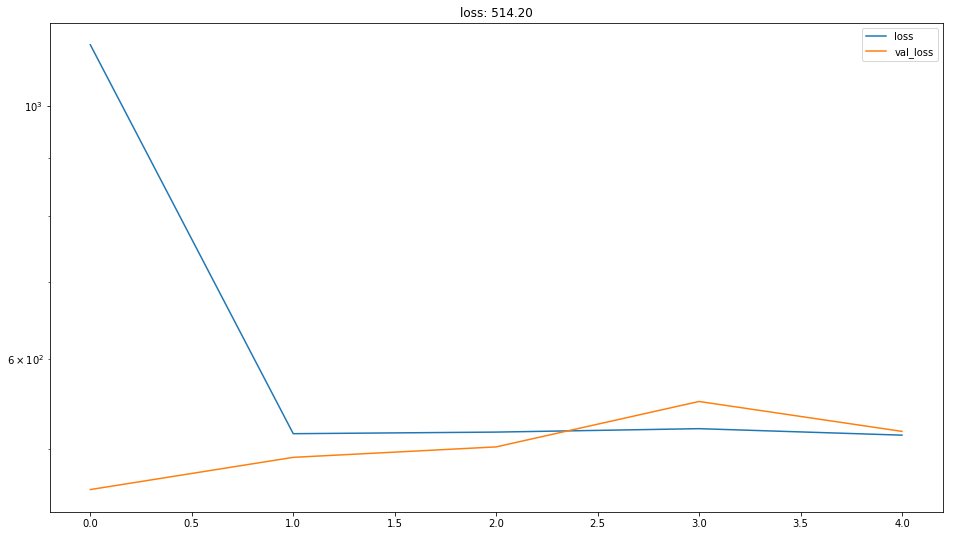

In [81]:
baseline_model.build_and_train(train, test, hp, callbacks=[plot_losses])

In [82]:
pred_baseline_nn_test = baseline_model.predict(test)

### Day Type Embeddings Model

In [11]:
daytype_components = pd.read_csv('../output/reference-link-embeddings.csv', index_col=0)

In [12]:
model = DayTypeEmbeddingsModel(daytype_components, pd.concat([cal_train, cal_test]))
model.choose_tod_bins(train)

In [85]:
import tensorflow.keras.backend as K

In [86]:
hp_train_normal_days, hp_val_normal_days = data_utils.split_normal_days_train_val(train_normal_days)
hp_train_special_days, hp_val_special_days = data_utils.split_special_days_train_val(train_special_days)
hp_train = pd.concat([hp_train_normal_days, hp_train_special_days])
hp_val = pd.concat([hp_val_normal_days, hp_val_special_days])

X_train = model.transform(hp_train, is_training = True)
Y_train = model.extract_y(hp_train)
X_val = model.transform(hp_val, is_training = False)
Y_val = model.extract_y(hp_val)

In [87]:
with open(f'../output/day_type_embeddings/test/{link_ref_slug}/hyperparameters.json', 'r') as f:
    hp_config = json.load(f)
    
hp = HyperParameters().from_config(hp_config)

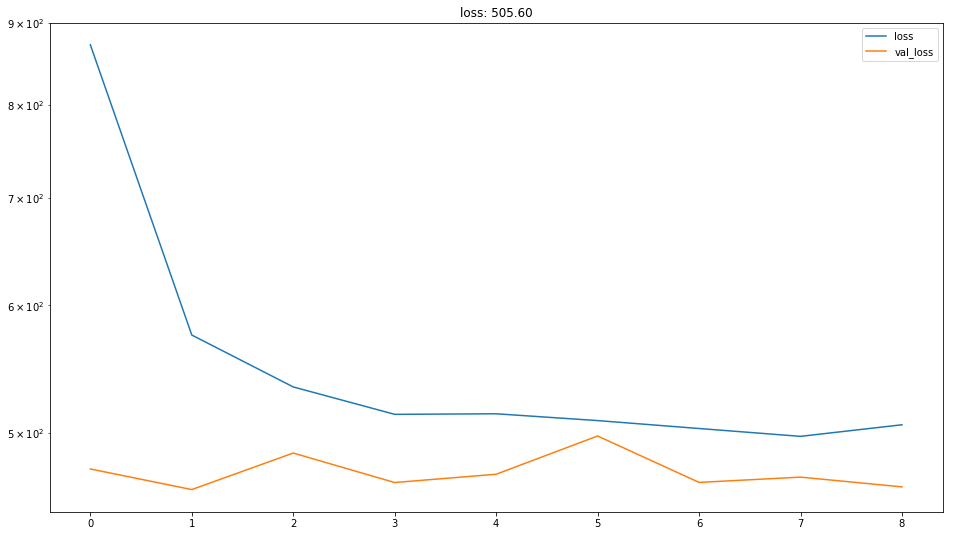

In [88]:
model.build_and_train(train, test, hp, callbacks=[plot_losses])

In [89]:
model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tod (InputLayer)          (None, 140)          0                                            
__________________________________________________________________________________________________
input_embedding (InputLayer)    (None, 4)            0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 140, 1)       0           input_tod[0][0]                  
__________________________________________________________________________________________________
fc_1 (Dense)                    (None, 100)          500         input_embedding[0][0]            
__________________________________________________________________________________________________
conv1d (Co

In [90]:
pred_day_type_embeddings_test = model.predict(test)

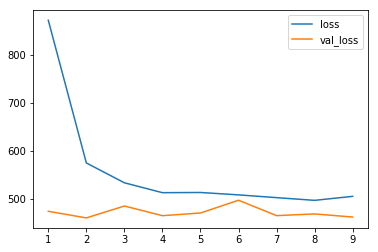

In [91]:
hist = pd.DataFrame(model.model.history.history)
hist.index += 1
hist.plot()

In [92]:
session.close()

In [93]:
def scoreboard(true, models, weights = None):
    if weights is None:
        weights = np.ones_like(true)
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    true = np.array(true)
    return pd.DataFrame([{
        'Model': k,
        'MAE': np.sum(np.abs(np.array(v) - true) * weights),
        'RMSE': np.sqrt(np.sum((np.array(v) - true)**2 * weights))
    } for k, v in models.items()]).set_index('Model')

## Test

In [94]:
scoreboard(test_, {
    'Simple Abs LR': test_pred_ex2,
    'Simple Abs NL': test_pred_ex3,
    #'Baseline: SVR': test_pred_svr_.fillna(0),    
    'Baseline: Cos/Sin': Y_pred_test_cossin_baseline_.fillna(0),
    'Baseline: One-hot': Y_pred_test_baseline_.fillna(0),
}, test_w).round(1).style.apply(notebook_utils.highlight_min, axis = 0)

NameError: name 'test_' is not defined

## Control

In [ ]:
scoreboard(test_control_, {
    'Simple Abs LR': test_control_pred_ex2,
    'Simple Abs NL': test_control_pred_ex3, 
    'Baseline: Cos/Sin': Y_pred_control_cossin_baseline_.fillna(0),
    'Baseline: One-hot': Y_pred_control_baseline_.fillna(0),
}, test_control_w).round(1).style.apply(notebook_utils.highlight_min, axis = 0)

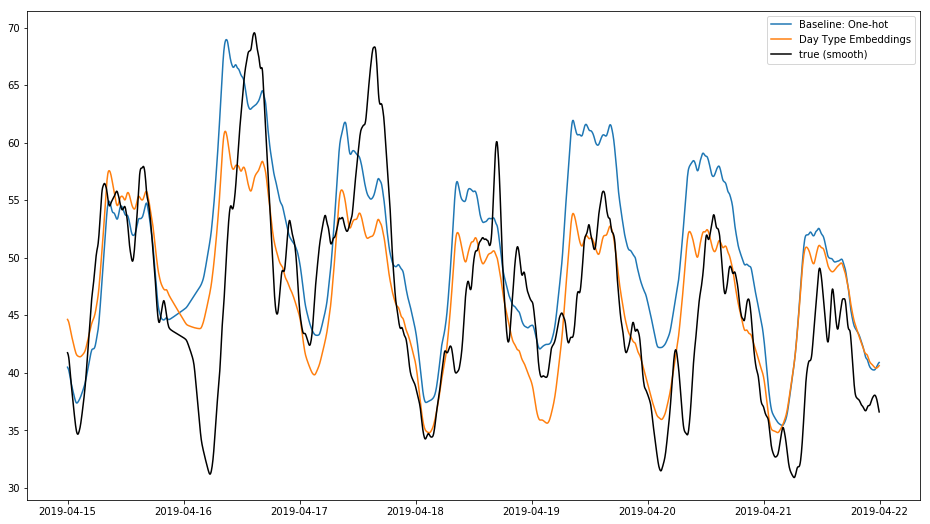

In [95]:
fig, ax = plt.subplots(figsize = (16, 9))


#ax.plot(day_hour_to_ts(test_pred_ex0), label = 'Simple Abs LR')
#ax.plot(day_hour_to_ts(test_pred_ex1), label = 'Simple Rel NL')
#ax.plot(day_hour_to_ts(test_pred_ex2), label = 'Simple Abs LR')
#ax.plot(day_hour_to_ts(test_pred_ex3), label = 'Simple Abs NL')
#ax.plot(day_hour_to_ts(test_pred_ex4), label = 'Simple Abs RNN')

#ax.plot(day_hour_to_ts(test_pred_svr_), label = 'Baseline: SVR')
#ax.plot(Y_pred_test_cossin_baseline, label = 'Baseline: Cos/Sin')
ax.plot(notebook_utils.smooth_align_df(pred_baseline_nn_test, smooth=50, freq=pred_freq), label = 'Baseline: One-hot')
ax.plot(notebook_utils.smooth_align_df(pred_day_type_embeddings_test, smooth=50, freq=pred_freq), label = 'Day Type Embeddings')

ax.plot(notebook_utils.smooth_align_df(test, smooth=50, freq=pred_freq), label = 'true (smooth)', color = 'k')

ax.legend()

AttributeError: 'NoneType' object has no attribute 'update'

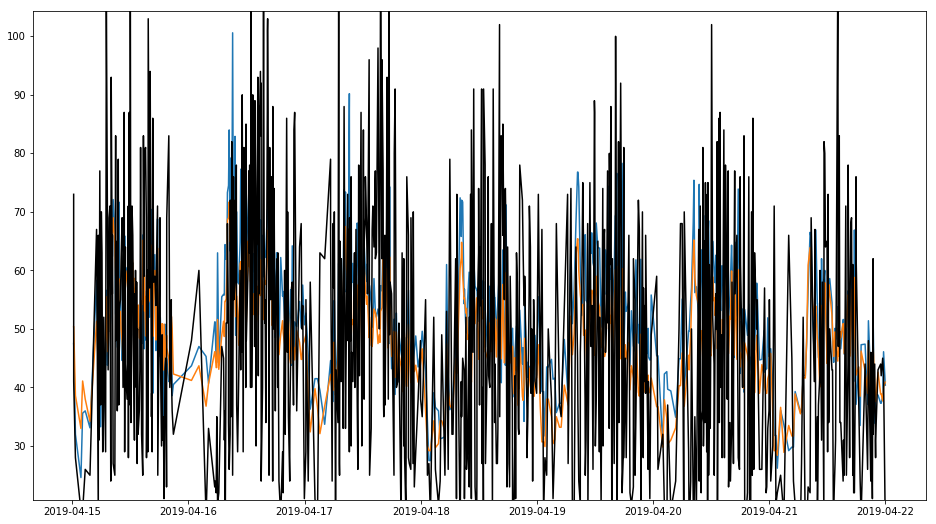

In [98]:
fig, ax = plt.subplots(figsize = (16, 9))


#ax.plot(day_hour_to_ts(test_pred_ex0), label = 'Simple Abs LR')
#ax.plot(day_hour_to_ts(test_pred_ex1), label = 'Simple Rel NL')
#ax.plot(day_hour_to_ts(test_pred_ex2), label = 'Simple Abs LR')
#ax.plot(day_hour_to_ts(test_pred_ex3), label = 'Simple Abs NL')
#ax.plot(day_hour_to_ts(test_pred_ex4), label = 'Simple Abs RNN')

#ax.plot(day_hour_to_ts(test_pred_svr_), label = 'Baseline: SVR')
#ax.plot(Y_pred_test_cossin_baseline, label = 'Baseline: Cos/Sin')
ax.plot(pred_baseline_nn_test, label = 'Baseline: One-hot')
ax.plot(pred_day_type_embeddings_test, label = 'Day Type Embeddings')

ax.plot(test, label = 'true (smooth)', color = 'k')

ax.legend()